<a href="https://colab.research.google.com/github/woojin9605/Practice/blob/main/DCGAN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.datasets as dset
import torchvision.transforms as T
import torchvision.utils as vutils

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
from IPython.display import HTML


manualseed = 999 # random seed 고정
random.seed(manualseed) # for numpy
torch.manual_seed(manualseed) # for torch

Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10/


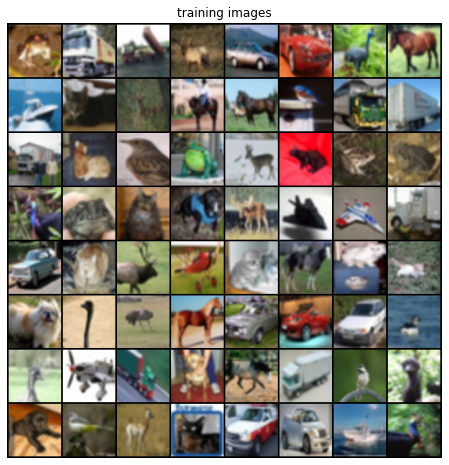

In [2]:
batch_size = 128
lat_z = 100
num_act = 64

transform = T.Compose([
              T.Resize(64),
              T.ToTensor(),
              T.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

dataset = dset.CIFAR10(root='./CIFAR10/',
                      download=True,transform=transform)
dataloader = DataLoader(dataset,batch_size=batch_size)

device = torch.device('cuda')

batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis('off')
plt.title('training images')
plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:64],
                             padding=2,normalize=True).cpu(),(1,2,0)))

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

def Generator():
  model = None
  model = nn.Sequential(
            nn.ConvTranspose2d(lat_z, num_act * 8, 4, 1, 0, bias=False),#4x4
            nn.BatchNorm2d(num_act * 8),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_act * 8, num_act * 4, 4, 2, 1, bias=False),#8x8
            nn.BatchNorm2d(num_act * 4),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_act * 4, num_act * 2, 4, 2, 1, bias=False),#16x16
            nn.BatchNorm2d(num_act * 2),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_act * 2, num_act, 4, 2, 1, bias=False),#32x32
            nn.BatchNorm2d(num_act),
            nn.ReLU(True),

            nn.ConvTranspose2d(num_act, 3, 4, 2, 1, bias=False), #64x64
            nn.Tanh()      
  )
  return model

def Discriminator():
  model = None
  model = nn.Sequential(
            nn.Conv2d(3, num_act, 4, 2, 1, bias=False),#32x32
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_act, num_act * 2, 4, 2, 1, bias=False),#16x16
            nn.BatchNorm2d(num_act * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_act * 2, num_act * 4, 4, 2, 1, bias=False),#8x8
            nn.BatchNorm2d(num_act * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_act * 4, num_act * 8, 4, 2, 1, bias=False),#4x4
            nn.BatchNorm2d(num_act * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(num_act * 8, 1, 4, 1, 0, bias=False),#1x1
            nn.Sigmoid()
  )
  return model

In [4]:
G = Generator().to(device)
G.apply(weights_init)
print('Generator: ',G)

D = Discriminator().to(device)
D.apply(weights_init)
print('Discriminator: ',D)

Generator:  Sequential(
  (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)
Discriminator:  Sequential(
  (0): Conv2d

In [5]:
fixed_noise = torch.randn(batch_size,lat_z,1,1,device=device)

criterion = nn.BCELoss()
real_label = 1
fake_label = 0

optimizerD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5,0.999))
optimizerG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5,0.999))

In [6]:
img_list = []
G_loss = []
D_loss = []
iters = 0
num_epochs = 25

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Update D, log(D(x)) + log(1 - D(G(z)))
        # log(D(x))
        optimizerD.zero_grad()
        x = data[0].to(device)
        b_size = x.shape[0] # 끄트머리 부분 batch는 기존과 다를 수 있으므로
        label = torch.full((b_size,), real_label,dtype=torch.float, device=device)

        output = D(x)
        output = output.view(-1,1).squeeze(1)
        errD_real = criterion(output, label)
        errD_real.backward()

        # log(1 - D(G(z))
        noise = torch.randn(b_size, lat_z, 1, 1, device=device)
        fake = G(noise)
        label.fill_(fake_label)

        output = D(fake.detach())
        output = output.view(-1,1).squeeze(1)
        errD_fake = criterion(output, label)
        errD_fake.backward()

        # log(D(x)) + log(1 - D(G(z)))
        errD = errD_real + errD_fake
        optimizerD.step()


        # Update G, log(D(G(z)))
        # log(D(G(z)))
        optimizerG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator

        output = D(fake)
        output = output.view(-1,1).squeeze(1)
        errG = criterion(output, label)
        errG.backward()

        optimizerG.step()

        if i == 0:
            print('[%d/%d][%d/%d]\tLossD: %.4f\tLossG: %.4f' % (epoch, num_epochs,i,len(dataloader),errD.item(),errG.item()))

        G_loss.append(errG.item())
        D_loss.append(errD.item())

        if ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
              fake = G(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake,padding=2,normalize=True))
    
        iters += 1

print('training finished')

[0/25][0/391]	LossD: 1.5856	LossG: 6.3599
[1/25][0/391]	LossD: 0.4989	LossG: 8.4600
[2/25][0/391]	LossD: 0.6304	LossG: 5.8304
[3/25][0/391]	LossD: 0.5193	LossG: 4.8955
[4/25][0/391]	LossD: 0.4998	LossG: 3.4793
[5/25][0/391]	LossD: 0.8868	LossG: 0.6144
[6/25][0/391]	LossD: 1.6203	LossG: 1.0141
[7/25][0/391]	LossD: 0.5108	LossG: 2.1745
[8/25][0/391]	LossD: 0.5604	LossG: 2.3712
[9/25][0/391]	LossD: 0.5564	LossG: 2.1684
[10/25][0/391]	LossD: 1.1567	LossG: 1.3568
[11/25][0/391]	LossD: 0.8165	LossG: 2.1455
[12/25][0/391]	LossD: 0.4802	LossG: 3.0252
[13/25][0/391]	LossD: 0.2063	LossG: 3.8023
[14/25][0/391]	LossD: 0.7207	LossG: 3.1872
[15/25][0/391]	LossD: 0.7427	LossG: 2.3103
[16/25][0/391]	LossD: 0.3120	LossG: 2.5307
[17/25][0/391]	LossD: 0.8898	LossG: 2.4125
[18/25][0/391]	LossD: 0.8734	LossG: 1.6206
[19/25][0/391]	LossD: 0.3926	LossG: 3.2706
[20/25][0/391]	LossD: 0.6944	LossG: 2.0435
[21/25][0/391]	LossD: 0.0125	LossG: 6.4155
[22/25][0/391]	LossD: 0.2883	LossG: 2.8327
[23/25][0/391]	LossD:

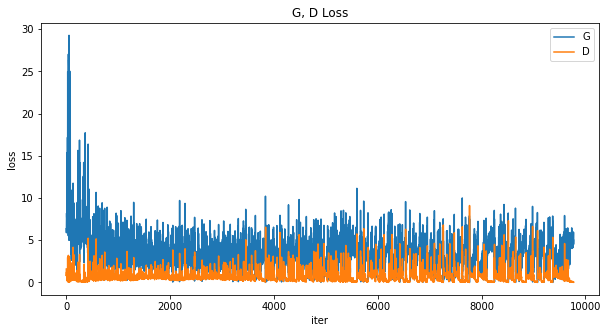

In [7]:
plt.figure(figsize=(10,5))
plt.title('G, D Loss')
plt.plot(G_loss,label='G')
plt.plot(D_loss,label='D')
plt.xlabel('iter')
plt.ylabel('loss')
plt.legend()
plt.show()

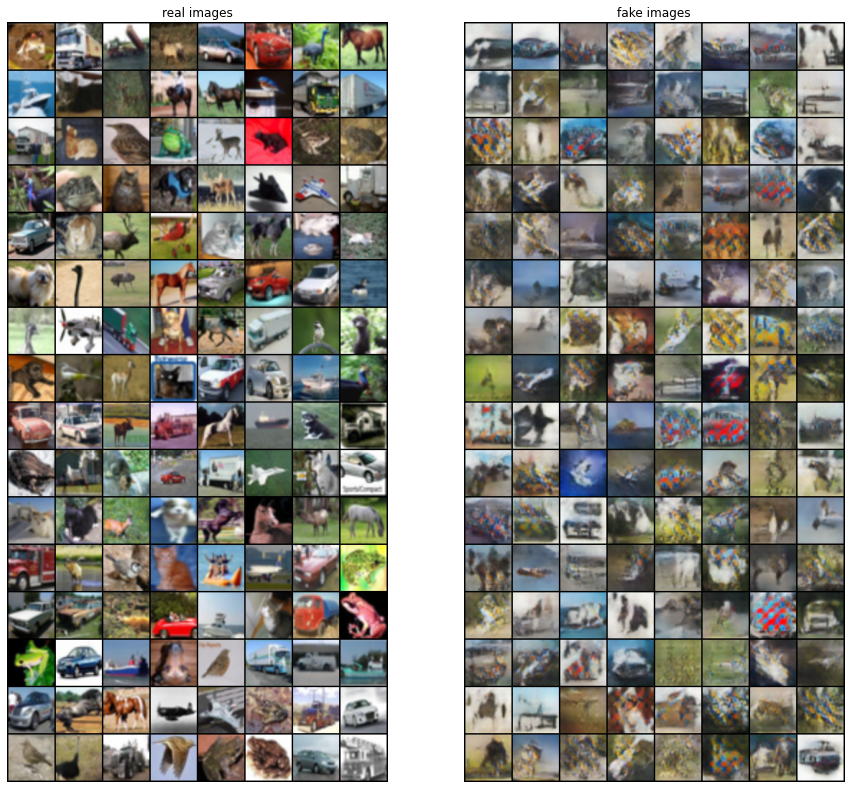

In [8]:
real_batch = next(iter(dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis('off')
plt.title('real images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:128],padding=2,normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis('off')
plt.title('fake images')
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()